# Macro Facial Expressions detection using keras

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
import pandas as pd

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

train_filepath="C:\\Users\\MSI\\Desktop\\DL\\Datasets\\CK+48\\"

Tensorflow version: 2.6.0


## Exploring the FER image dataset

In [40]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0
    for expression in os.listdir(train_filepath):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img(train_filepath + expression + "\\" +os.listdir(train_filepath + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

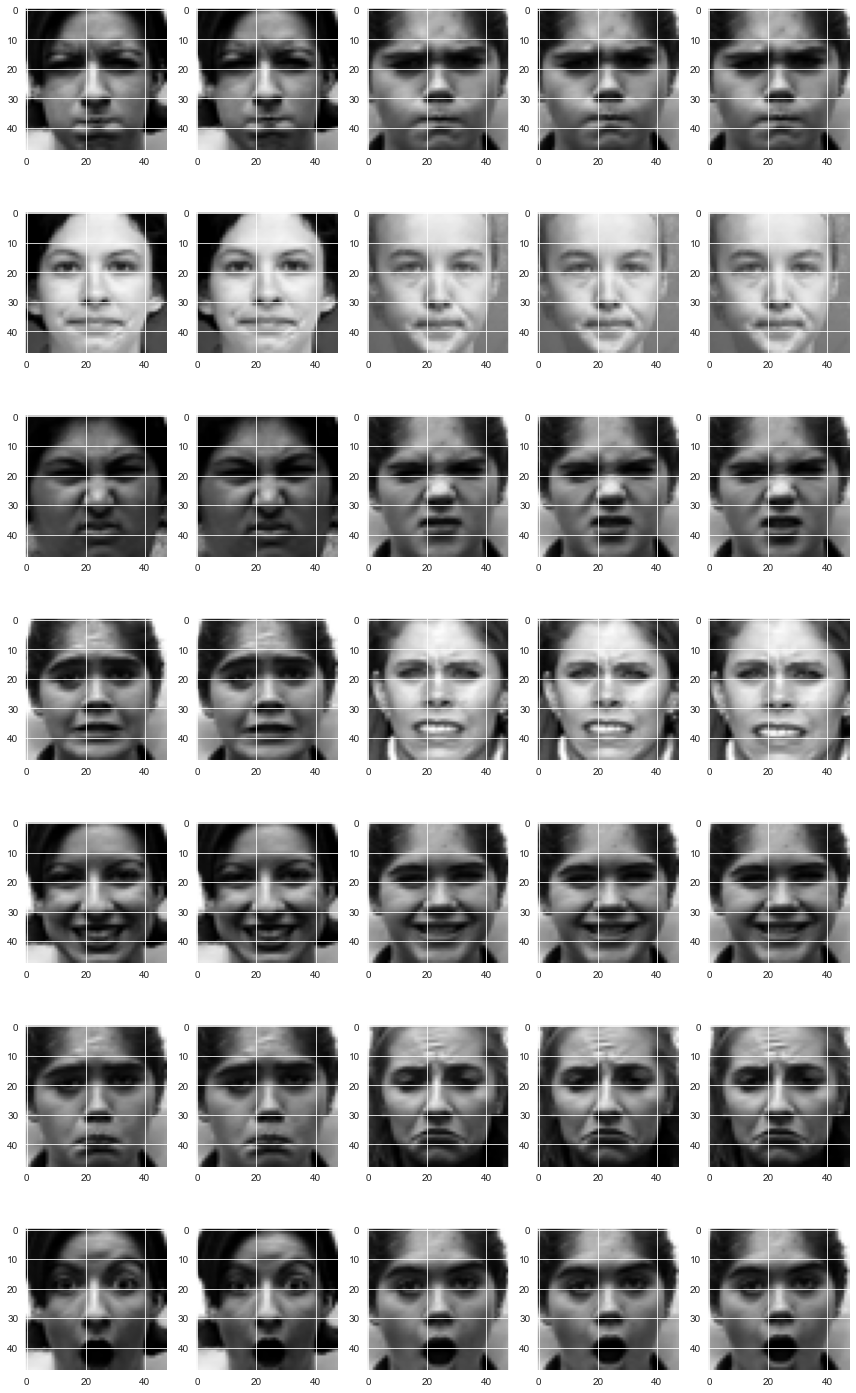

In [23]:
plot_example_images(plt).show()

In [24]:
for expression in os.listdir(train_filepath):
    print(str(len(os.listdir(train_filepath + expression )))+" "+ expression+ " images")

135 anger images
54 contempt images
177 disgust images
75 fear images
207 happy images
84 sadness images
249 surprise images


## Defining the CNN model

In [41]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

def create_new_model():
    model = Sequential()

    #1 - conv
    model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    #2 conv
    model.add(Conv2D(128,(5,5),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    #3 conv
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # conv
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))

    return model


In [66]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

img_size= 48
batch_size= 10
datagen_train =  ImageDataGenerator(horizontal_flip=True)

#datagen_train =  ImageDataGenerator(horizontal_flip=True,validation_split=0.2)

fold_var = 1
kf = StratifiedKFold(n_splits = 4, shuffle=True,random_state=7)
datapaths = datagen_train.flow_from_directory(directory=train_filepath,target_size=(img_size,img_size),color_mode='grayscale', batch_size=batch_size,class_mode='categorical')
data=pd.DataFrame({"filename":datapaths.filenames,
                      "label":datapaths.classes})
data.to_csv("data.csv",index=False)
data = pd.read_csv('data.csv',dtype=str)
#print(train_generator.num_classes)

Found 981 images belonging to 7 classes.


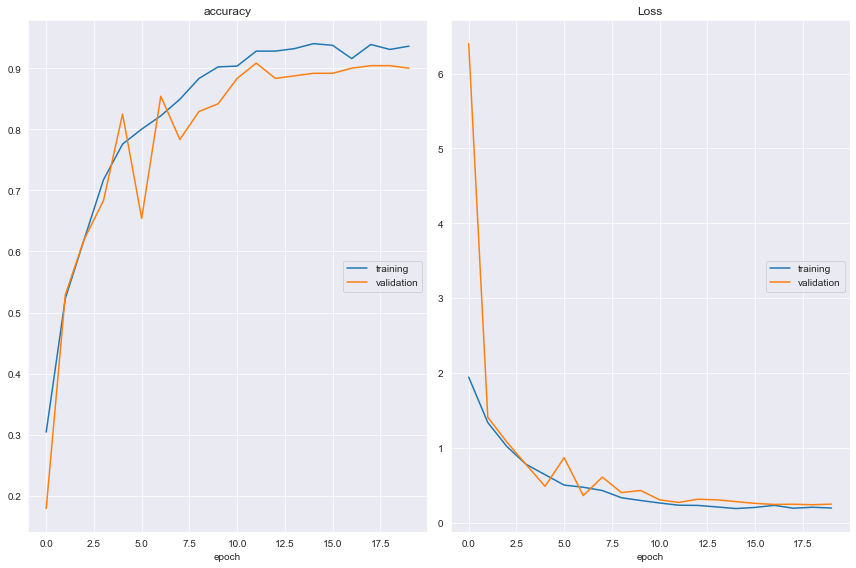

accuracy
	training         	 (min:    0.304, max:    0.940, cur:    0.936)
	validation       	 (min:    0.179, max:    0.908, cur:    0.900)
Loss
	training         	 (min:    0.188, max:    1.944, cur:    0.195)
	validation       	 (min:    0.239, max:    6.399, cur:    0.247)

Epoch 00020: val_accuracy did not improve from 0.90833
16/16 [==============================] - 0s 7ms/step - loss: 0.2748 - accuracy: 0.9061
Score for fold 4: loss of 0.27483120560646057; accuracy of 90.61224460601807%


In [67]:

for train_index, val_index in kf.split(np.zeros(981),data[['label']]):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_var} ...')
    training_data = data.iloc[train_index]
    validation_data = data.iloc[val_index]
    train_generator = datagen_train.flow_from_dataframe(training_data,directory=train_filepath, x_col = "filename", y_col = "label",target_size=(img_size,img_size),color_mode='grayscale', batch_size=batch_size,class_mode='categorical',shuffle=True)

    validation_generator = datagen_train.flow_from_dataframe(validation_data,directory=train_filepath, x_col = "filename", y_col = "label",target_size=(img_size,img_size),color_mode='grayscale', batch_size=batch_size,class_mode='categorical',shuffle=True)

    # CREATE NEW MODEL
    model = create_new_model()
	# COMPILE NEW MODEL
    opt = Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy',
		      optimizer=opt,
		      metrics=['accuracy'])

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint('\\ck_models\\'+get_model_name(fold_var),
							monitor='val_accuracy', verbose=1,
							save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.00001,model='auto')
    callbacks = [PlotLossesKerasTF(),checkpoint, reduce_lr]

    epochs = 20
    steps_per_epoch = train_generator.n//train_generator.batch_size
    validation_steps = validation_generator.n//validation_generator.batch_size

    history = model.fit(train_generator,
			    epochs=epochs,
                steps_per_epoch=steps_per_epoch,
			    callbacks=callbacks,
			    validation_data=validation_generator,
                validation_steps=validation_steps)

    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("/ck_models/model_"+str(fold_var)+".h5")

    results = model.evaluate(validation_generator)
    print(f'Score for fold {fold_var}: {model.metrics_names[0]} of {results[0]}; {model.metrics_names[1]} of {results[1]*100}%')
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1



## Training the model

In [68]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(VALIDATION_ACCURACY)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {VALIDATION_LOSS[i]} - Accuracy: {VALIDATION_ACCURACY[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(VALIDATION_ACCURACY)} (+- {np.std(VALIDATION_ACCURACY)})')
print(f'> Loss: {np.mean(VALIDATION_LOSS)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0809137225151062 - Accuracy: 0.9756097793579102%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4299604594707489 - Accuracy: 0.8489795923233032%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5168806910514832 - Accuracy: 0.8367347121238708%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.27483120560646057 - Accuracy: 0.9061224460601807%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.8918616324663162 (+- 0.05498856614198137)
> Loss: 0.3256465196609497
------------------------------------------------------------------------


In [69]:
model_json = model.to_json()
with open("ckmodel.json","w") as json_file:
    json_file.write(model_json)